<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <img src="https://francia.unam.mx/wp-content/uploads/2021/10/Logo-UNAM-Azul-Landscape.png" alt="UNAM" width="225" height="125">
  <img src="https://mcdonaldinstitute.ca/wp-content/uploads/2018/05/PI-logo-2017-Black-1280x424.png.webp" alt="Perimeter" width="200" height="100">
  <img src="https://swanseauniversity.cloud.panopto.eu/Panopto/ContentCache/637582254009215017/_branding/f80a49ed-5120-415e-89fe-ab8900ad7d40/637582253354333331_largelogo.png" alt="Swansea" width="225" height="125">
</div>


<h1 align="center">
Stochastic Gravitational Waves from Primordial Black Holes<br>
in Dwarf Galaxies
</h1>

<h3 align="center">
Tadeo D. Gómez-Aguilar $^{a,\dagger}$, Encieh Erfani $^{b}$ and Nayeli Marisol Jiménez Cruz $^{c}$
</h3>

#### $^{a}$Instituto de Ciencias Físicas, Universidad Nacional Autónoma de México, 62210, Cuernavaca, Morelos, México. $^{b}$Perimeter Institute for Theoretical Physics, Waterloo, ON N2L 2Y5, Canada. $^{c}$Physics Department, Swansea University, SA28PP, United Kingdom.


**Abstract**
<div style="background-color: #ffe4e1; padding: 10px;">
We investigate the Stochastic Gravitational Wave Background (SGWB) generated by Close Hyperbolic Encounters (CHEs) of Primordial Black Holes (PBHs) within dark matter-dominated dwarf galaxies. Building upon our previous work, this study incorporates the full hierarchical merger history of PBHs to evaluate their cumulative contribution to the SGWB. Our framework identifies the conditions under which gravitational waves from CHEs
and successive PBH mergers become significant components of the observable SGWB, and allows for a direct comparison with signals from standard PBH mergers. We determine the parameter space in which these signals may be detected by next-generation gravitational wave observatories, including the Einstein Telescope, LISA, Pulsar Timing Arrays (PTAs), and the Square Kilometre Array (SKA). Furthermore, we present numerical criteria that define the validity range of our analytical models.
</div>


**Corresponse author:**
$^{\dagger}$[tadeo.dga@icf.unam.mx](mailto:tadeo.dga@icf.unam.mx)

<h3 align="center">
Code writed by Tadeo D.
</h3>
    
<h5 align="right">
Dedicated to Elizabeth América Flores Frías.
</h5>

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
from astropy import constants as cte0

In [2]:
# --- Constantes ---
c = 299792458 # m/s
c_ast = 299792.458 # km/s
G = 6.6743e-11 # m^3 / (kg s^2)
G_ast = 4.517103049894964e-30 # pc^3 / (s^2 solMass)

In [8]:
# Parámetros del cúmulo
M_DM_cluster = 1e5
M_PBH = 1e-14
N_PBH_i_Msun = M_DM_cluster / (2 * M_PBH)
N_PBH_j_Msun = M_DM_cluster / (2 * M_PBH)
N_PBH_total = 2 * N_PBH_i_Msun
R_cluster = 1.1#1.0961250

# Radios de evaluación
r_values_pc = np.linspace(0.1, R_cluster, 10)

In [9]:
print("BOUNDARY CONDITIONS TO CLUSTER")
print(f"Number of PBHs into cluster: {N_PBH_total:.0f} of {M_PBH} Solar Masses")
print(f"Cluster radius (parsecs): {R_cluster:.1f}")

BOUNDARY CONDITIONS TO CLUSTER
Number of PBHs into cluster: 10000000000000000000 of 1e-14 Solar Masses
Cluster radius (parsecs): 1.1


radius (pc)    n_pbh(r)
0.10           1757102854686943744
0.21           1638556162863446272
0.32           1459994338630016000
0.43           1250551069119076352
0.54           1037126560533119104
0.66           838978088304460160
0.77           666586849228074368
0.88           523314813126508608
0.99           407969294672650944
1.10           317072331479070976
-8549491711066185088


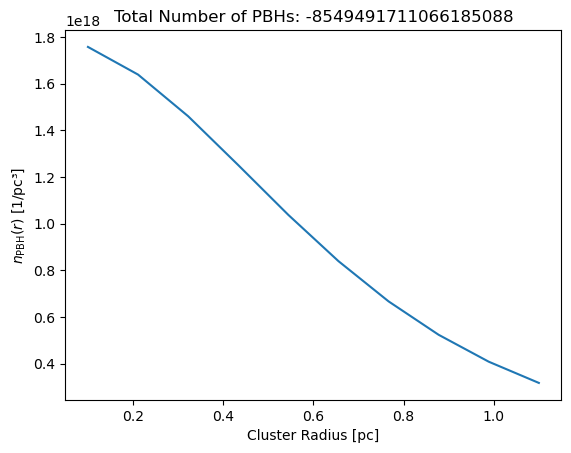

In [11]:
# --- Funciones físicas ---
def rho(r):
    factor = (3 * M_DM_cluster) / (4 * np.pi * R_cluster**3)
    shape = 1 + (r / R_cluster)**2
    return factor * shape**(-2.5)

def n_pbh(r, M_pbh):
    return (rho(r) / M_pbh)

n_PBH_r = np.array([
    round(n_pbh(r, M_PBH))
    for r in r_values_pc
])
n_total = np.sum(n_PBH_r)

# Imprimir
print(f"{'radius (pc)':<15}{'n_pbh(r)'}")
print("=" * 24)
for r, n in zip(r_values_pc, n_PBH_r):
    print(f"{r:<15.2f}{n:<4}")

print(n_total)

plt.plot(r_values_pc, n_PBH_r)
plt.xlabel("Cluster Radius [pc]")
plt.ylabel("$n_\\mathrm{PBH}(r)$ [1/pc³]")
plt.title(f"Total Number of PBHs: {int(n_total)}")
plt.show()

In [12]:
def phi(r, M_cluster):
    phi_r = ((G_ast * M_cluster / R_cluster) * (1 + (r / R_cluster)**2)**(-0.5))
    return phi_r * 9.5214e26 # km^2/s^2

def f_E(E, N_pbh, M_cluster):
    E = E / 9.5214e26
    num = 24 * np.sqrt(2) * N_pbh * R_cluster**2 * E**(3.5)
    denom = 7 * np.pi**3 * G_ast**5 * M_cluster**5
    return (num / denom) * 3.404e-41

def integrand(E_val, r, N_pbh, M_cluster):
    phi_val = phi(r, M_cluster)
    delta_E = 2 * (phi_val - E_val)
    return f_E(E_val, N_pbh, M_cluster) * delta_E**1.5

def mean_square_velocity(r, M_cluster, N_pbh, M_pbh):
    n_r = (rho(r) / M_pbh)
    if n_r == 0:
        return 0.0
    phi_r = phi(r, M_cluster)
    integral, _ = spi.quad(integrand, 0, phi_r, args=(r, N_pbh, M_cluster))
    return np.sqrt((4 * np.pi / n_r) * integral)

In [15]:
v_mean_values = np.array([
    mean_square_velocity(r, M_DM_cluster, N_PBH_total, M_PBH)
    for r in r_values_pc
])

for r, v in zip(r_values_pc, v_mean_values):
    print(f"r = {r:.2f},  v_rms = {v:.3f}")

v_0 = np.mean(v_mean_values) #(u.km / u.s)

print(f"\n v0 = {v_0:.3f}")

r = 0.10,  v_rms = nan
r = 0.21,  v_rms = nan
r = 0.32,  v_rms = nan
r = 0.43,  v_rms = nan
r = 0.54,  v_rms = nan
r = 0.66,  v_rms = nan
r = 0.77,  v_rms = nan
r = 0.88,  v_rms = nan
r = 0.99,  v_rms = nan
r = 1.10,  v_rms = nan

 v0 = nan


/var/folders/8z/v5ctqgzj6976wfqxw2yn2m1w0000gn/T/ipykernel_76800/2951194252.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * np.pi / n_r) * integral)


In [ ]:
km_to_pc = 1 / 3.085677581e13 
# --- Secciones eficaces ---
def sigma_BPBH(m1, m2, v_i, v_j):
    G_astro = G_ast
    c_astro = c_ast
    prefactor = (340 * np.pi / 3)**(2/7)
    num = np.pi * prefactor * G_astro**2 * (m1 + m2)**(10/7) * (m1 * m2)**(2/7)
    if v_i == v_j:
        denom = c_astro**(10/7) * np.abs(v_0)**(18/7)
    else:
        denom = c_astro**(10/7) * (np.abs(v_i - v_j))**(18/7)
    return (num / denom) * (3.085677581e13)**4

def sigma_CHES(m1, m2, v_i, v_j):
    G_astro = G_ast
    e = 1.000001
    if v_i == v_j:
        b = (G_astro * (m1 + m2) / v_i**2)
    else:
        b = (G_astro * (m1 + m2) / (np.abs(v_i - v_j))**2)
    b = b / (3.085677581e13**-2)
    return np.pi * b**2 * (e**2 - 1)

In [ ]:
# --- Integral I ---
def integrand_I(r_i, r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    if M_pbh_i == M_pbh_j:
        n_i = n_pbh(r_i, M_pbh_i) / 2
        n_j = n_i
        v_i = mean_square_velocity(r_i, M_cluster, 2*N_pbh_i, M_pbh_i) * km_to_pc
        v_j = v_i
    else:
        n_i = n_pbh(r_i, M_pbh_i)
        v_i = mean_square_velocity(r_i, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc
        v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc
    term = (v_j + v_i)**(3/7) - abs(v_j - v_i)**(3/7)
    return r_i**2 * (n_i / v_i) * term

def I_rj(r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster):
    args = (r_j, N_pbh_i, M_pbh_i, N_pbh_j, M_pbh_j, M_cluster)
    integral, _ = spi.quad(integrand_I, 0.1 * R_cluster, R_cluster, args=args)
    return integral

I_values = np.array([I_rj(r_j, N_PBH_i_Msun, M_PBH, N_PBH_j_Msun, M_PBH, M_DM_cluster) for r_j in r_values_pc])
coeffs = np.polyfit(r_values_pc, I_values, 3)

In [ ]:
# --- Gamma ---
def Gamma_rj(r_j, N_pbh_j, M_pbh_j, N_pbh_i, M_pbh_i, M_cluster):
    n_j = n_pbh(r_j, M_pbh_j)
    v_j = mean_square_velocity(r_j, M_cluster, N_pbh_j, M_pbh_j) * km_to_pc
    v_i = mean_square_velocity(r_j, M_cluster, N_pbh_i, M_pbh_i) * km_to_pc
    sigma_B = sigma_BPBH(M_pbh_i, M_pbh_j, v_i/km_to_pc, v_j/km_to_pc)
    sigma_C = sigma_CHES(M_pbh_i, M_pbh_j, v_i/km_to_pc, v_j/km_to_pc)
    if v_j == 0 or n_j == 0:
        return 0, 0
    I_val = np.polyval(coeffs, r_j)
    if v_i == v_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, N_pbh_i*2, M_pbh_i)
            for r in r_values_pc]
        )
        v_0 = np.mean(v_mean_values) * km_to_pc
        gamma_BBH = (v_0)**(18/7) * (14 * np.pi / 3) * sigma_B * (n_j / v_j) * I_val
        gamma_CHE = (v_0)**(18/7) * (14 * np.pi / 3) * sigma_C * (n_j / v_j) * I_val
    else:
        gamma_BBH = (np.abs(v_i - v_j))**(18/7) * (14 * np.pi / 3) * sigma_B * (n_j / v_j) * I_val
        gamma_CHE = (np.abs(v_i - v_j))**(18/7) * (14 * np.pi / 3) * sigma_C * (n_j / v_j) * I_val
    return gamma_BBH, gamma_CHE

In [ ]:
Gamma_BBH_values = np.array([
    Gamma_rj(r_j, N_PBH_j_Msun, M_PBH, N_PBH_i_Msun, M_PBH, M_DM_cluster)[0]
    for r_j in r_values_pc
])

Gamma_CHES_values = np.array([
    Gamma_rj(r_j, N_PBH_j_Msun, M_PBH, N_PBH_i_Msun, M_PBH, M_DM_cluster)[1]
    for r_j in r_values_pc
])

for r, g_bbh, g_che in zip(r_values_pc, Gamma_BBH_values, Gamma_CHES_values):
    print(f"r = {r:.3f} pc | Gamma_BBH = {g_bbh:.3e} [1/s] | Gamma_CHE = {g_che:.3e} [1/s]")

# Graficar
plt.figure(figsize=(7,5))
plt.plot(r_values_pc, Gamma_BBH_values, 'o-', label=r'$\Gamma_{\mathrm{BBH}}$')
plt.plot(r_values_pc, Gamma_CHES_values, 's-', label=r'$\Gamma_{\mathrm{CHE}}$')
plt.xlabel("Radius $r$ [pc]")
plt.ylabel(r"$\Gamma$ [1/s]")
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# Edad del universo
age_universe_Gyr = 13.786885302009708  # Gyr
age_universe_yr = age_universe_Gyr * 1e9  # yr

# Conversión de tasas a unidades por año
seconds_per_year = 3.15576e7  # s/yr
Gamma_BBH_values_yr = Gamma_BBH_values * seconds_per_year
Gamma_CHES_values_yr = Gamma_CHES_values * seconds_per_year

time_first_merger_yr =  1/Gamma_BBH_values_yr
time_first_merger_Gyr = time_first_merger_yr / 1e9

time_first_ches_yr = 1/Gamma_CHES_values_yr
time_first_ches_Gyr = time_first_ches_yr / 1e9

In [ ]:
print(f"{'Gamma_BPBH(yr^-1)':<20}{'Time to 1st merger (Gyr)':<28}{'Gamma_CHES(yr^-1)':<20}{'Time to 1st CHEs (yr)':<28}")
print("=" * 90)
for i in range(len(r_values_pc)):
    print(f"{Gamma_BBH_values_yr[i]:<20.3e}{time_first_merger_Gyr[i]:<28.3e}{Gamma_CHES_values_yr[i]:<20.3e}{time_first_ches_yr[i]:.3e}")


time_z_20 = cosmo.age(20).to(u.yr).value
delta_t_merger = np.min(time_first_merger_yr)
print("\nTime necessary to all PBHs\nfrom first radius coallesences:", delta_t_merger/1e9, "Gyr")

delta_t_CHEs = np.min(time_first_ches_yr)# + time_z_20
print("\nTime necessary to maximum probability\nto produces CHEs in the first shell: ",delta_t_CHEs,"years")

In [ ]:
# --- Constantes ---
G_SI = 6.67430e-11             # m³ / (kg·s²)
c_SI = 2.99792458e8            # m/s
Msun_kg = 1.98847e30           # kg
pc_m = 3.085677581e16          # m
AU_m = 1.495978707e11          # m
erg_in_joule = 1e-7            # 1 erg = 1e-7 J
AU_pc = AU_m / pc_m            # 1 AU in parsecs
seconds_per_year = 3.15576e7   # s/yr

In [ ]:
def R_Swarzschild(m):
    return (2 * G_SI * m * Msun_kg) / c_SI**2 / pc_m

# --- Energía radiada BBH ---
def E_rad_GW(m1, m2):
    # --- Parámetros de separación inicial y final ---
    if m1<m2:
        a0 = (2 * G_SI * m2 * Msun_kg) / c_SI**2 / pc_m   # pc
    if m2<m1:
        a0 = (2 * G_SI * m1 * Msun_kg) / c_SI**2 / pc_m   # pc
    if m1==m2:
        a0 = (2 * G_SI * m1 * Msun_kg) / c_SI**2 / pc_m   # pc
    a1 = 0.01 * AU_pc  # pc
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg

    def integrand(a_pc):
        a_m = a_pc * pc_m
        return (G_SI * m1_kg * m2_kg) / (2 * a_m**2) * pc_m  # J

    integral, _ = spi.quad(integrand, a0, a1)
    return integral / erg_in_joule  # erg

# --- Masa final tras fusión BBH ---
def final_mass_GW(m1, m2):
    E_rad = E_rad_GW(m1, m2) * erg_in_joule  # J
    m_total = (m1 + m2) * Msun_kg
    m_final = m_total - E_rad / c_SI**2
    return m_final / Msun_kg  # M_sun

# --- Radio mínimo para CHES (en parsecs) ---
def r_min_CHES(m1, m2, K=1e-5):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    R_sch = lambda m: 2 * G_SI * m / c_SI**2  # m
    #return K * (R_sch(m1_kg) + R_sch(m2_kg)) / pc_m  # pc
    return (G_SI * (m1_kg + m2_kg) / (v_0*1e3)**2) * K / pc_m

# --- Energía radiada CHES ---
def E_rad_CHES(m1, m2, e=1.000001, K=1e-5):
    m1_kg = m1 * Msun_kg
    m2_kg = m2 * Msun_kg
    M = m1_kg + m2_kg
    r_min_m = r_min_CHES(m1, m2, K) * pc_m  # m

    # f(e) factor (Eq. 18)
    term1 = 24 * np.arccos(-1 / e) * (1 + (73/24)*e**2 + (37/96)*e**4)
    term2 = np.sqrt(e**2 - 1) * (301/6 + (673/12)*e**2)
    f_e = (1 / (1 + e)**(7/2)) * (term1 + term2)

    E_rad = (8/15) * G_SI**(3.5) * np.sqrt(M) * m1_kg**2 * m2_kg**2 / (c_SI**5 * r_min_m**(3.5)) * f_e
    return E_rad / erg_in_joule  # erg

In [ ]:
# --- Evaluación de energías y masa final ---
E_BBH_event = E_rad_GW(M_PBH, M_PBH)             # erg
E_CHES_event = E_rad_CHES(M_PBH, M_PBH)                  # erg
final_masses = final_mass_GW(M_PBH, M_PBH)       # M_sun

In [ ]:
time_values_interval_0 = np.linspace(1e3, delta_t_CHEs, 300) #Years
time_values_interval_0 = np.insert(time_values_interval_0, 0, 0.0)
time_values_interval_1 = np.linspace(delta_t_CHEs, 3.3e+09, 500) #Years
time_values_interval = np.concatenate((time_values_interval_0, time_values_interval_1[1:]))

t_yr=[]
redshift_evaluated_0 = []
for t in time_values_interval:
    t_yr.append(t + time_z_20)
    t_gyr = (t + time_z_20) / 1e9  # Gyr
    z = z_at_value(cosmo.age, t_gyr * u.Gyr, zmax=22).value
    redshift_evaluated_0.append(z)

time_period_1_yr = time_values_interval[799] #yr
time_period_1_Gyr = time_values_interval[799]/1e9 #Gyr
time_period_seconds = ((time_period_1_yr * u.yr).to(u.s)).value
print(time_period_1_Gyr, time_period_seconds, redshift_evaluated_0[799])

In [ ]:
N_CHES_0 = np.zeros_like(time_values_interval)
E_dot_CHES_0 = np.zeros_like(time_values_interval)
N_BBH_0 = np.zeros_like(time_values_interval)
E_dot_BBH_0 = np.zeros_like(time_values_interval)
BPBH_ALL_PERIOD = []
idx_first_all = None
first_bbh_idx = None
Probabilidad_total = np.zeros_like(time_values_interval)
Probabilidad_total_bbh = np.zeros_like(time_values_interval)
for i, t in enumerate(time_values_interval):
    # CHEs
    Prob_CHES_emit = Gamma_CHES_values_yr * t
    Proptot = np.sum(Prob_CHES_emit)
    Probabilidad_total[i] = Proptot
    #print("--> elapsep time(yr):",t)
    #print("Prob_CHES_r:",Prob_CHES_emit, "Proptot =", Proptot)
    N_CHES = np.round(Prob_CHES_emit * (n_PBH_r / 2))
    #print(N_CHES)
    if np.any(N_CHES == 0):
        N_CHES = np.zeros_like(Prob_CHES_emit)
    #print(N_CHES)
    if np.all(N_CHES > 0) and idx_first_all is None:
        idx_first_all = i
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t, "years")
        print("Time necesary to obtain 1 CHEs in all radius of the Cluster:", t/1e9, "Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
    N_CHES_tot = np.sum(N_CHES)
    N_CHES_0[i] = N_CHES_tot
    if t==0.:
        E_dot_CHES_shell = 0.
    else:
        E_dot_CHES_shell = (N_CHES_tot * E_CHES_event)# / (t)# * 3.15576e7)
    #print(N_CHES_tot, E_dot_CHES_shell)
    E_dot_CHES_shell_tot = np.sum(E_dot_CHES_shell)
    E_dot_CHES_0[i] = E_dot_CHES_shell_tot

    # BBH
    Prob_BPBH_form = Gamma_BBH_values_yr * t
    Proptot_bbh = np.sum(Prob_BPBH_form)
    Probabilidad_total_bbh[i] = Proptot_bbh
    #print("Prob_BBH_r:",Prob_BPBH_form, "Proptot_form_bbh =", Proptot_bbh)
    N_BBH = np.where(Prob_BPBH_form * (n_PBH_r/2) > 0.95, np.round(Prob_BPBH_form * (n_PBH_r)), 0.0)
    if np.any(N_BBH == 0):
        N_BBH = np.zeros_like(Prob_BPBH_form)
    N_BBH_tot = np.sum(N_BBH)
    if first_bbh_idx is None and N_BBH_tot > 0:
        first_bbh_idx = i
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t} years")
        print(f"Time necesary to obtain mergers in all radius of the Cluster: {t/1e9} Gyr")
        print("Redshift:", z_at_value(cosmo.age, ((t + time_z_20) / 1e9) * u.Gyr, zmax=25).value)
        #print(N_BBH)
        N_BPBH_0G = N_BBH
        #print(N_BBH_tot)
    #print("Binary in every r:", N_BBH)
    N_BBH_0[i] = N_BBH_tot
    E_dot_BBH_shell = (N_BBH * E_BBH_event) #/ (t * 3.15576e7)
    E_dot_BBH_shell_tot = np.sum(E_dot_BBH_shell)
    E_dot_BBH_0[i] = E_dot_BBH_shell_tot
print("\nIf we consider a especific time to evaluated we have:")
print(N_BBH, "\nTotal number of PBHs of the first period", N_BBH_tot)
#print(t/1e9, "Gyr")
BPBH_ALL_PERIOD.append(N_BBH_tot) #Before a total time to evaluated

In [ ]:
POPULATION_BPBH_BY_GENERATION = [N_BBH_tot]
EMISSION_GW_OF_BPBH = [E_dot_BBH_shell_tot]
NUMBER_OF_CHES_BY_GENERATION = [N_CHES_tot]
EMISSION_GW_OF_CHES = [E_dot_CHES_shell_tot]
PERIOD_OF_EVOLUTION_GYR = [time_period_1_Gyr]
Z_PERIOD = [redshift_evaluated_0[-1]]

print("Total number of PBHs of the first period", N_BBH_tot, "with E_GW",E_dot_BBH_shell_tot)
#print(N_BBH, "Total number of PBHs of the first period", N_BBH_tot, E_dot_BBH_shell_tot)
#print(N_CHES, "Total number of PBHs of the first period", N_CHES_tot, E_dot_CHES_shell_tot)
print("Total number of CHES of the first period", N_CHES_tot, "with E_GW", E_dot_CHES_shell_tot)
print("Duration of period (Gyr):",time_period_1_Gyr, "\nDuration of period (s):",time_period_seconds)
#print(redshift_evaluated_0[-1])

In [ ]:
# Recupera los valores críticos
critical_time_yr = time_values_interval[idx_first_all]        # años
critical_time_gyr = critical_time_yr / 1e9                   # Gyr
critical_redshift = redshift_evaluated_0[idx_first_all]
critical_Edot = E_dot_CHES_0[idx_first_all]
critical_abs_age_gyr = (time_z_20 + time_values_interval[idx_first_all]) / 1e9

critical_merger_gyr = time_values_interval[first_bbh_idx]/1e9
critical_merger_redshift = redshift_evaluated_0[first_bbh_idx]
critical_merger_Edot = E_dot_BBH_0[first_bbh_idx]
critical_merger_age_gyr = (time_z_20 + time_values_interval[first_bbh_idx]) / 1e9

# --- vs tiempo evolution (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot(time_values_interval/1e9, E_dot_CHES_0, color='blue', linestyle = '-.', label='CHEs GW Power')
plt.plot(critical_time_gyr, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n({critical_time_yr/1e9:.3e} yr)')
plt.plot(time_values_interval/1e9, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_gyr, critical_merger_Edot, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(time_period_1_Gyr, color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Evolution Elapsed Time[Gyr]')
plt.ylabel(r'$\dot{E}_{\mathrm{GWs}}$ [erg]')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_time_evolution.pdf')
plt.show()

# --- vs edad absoluta (en Gyr) ---
plt.figure(figsize=(8,5))
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_CHES_0, color='blue', linestyle = '-.', label='CHEs GW Power')
#plt.axvline(critical_abs_age_gyr, color='red', ls='--', lw=2,
#            label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot(critical_abs_age_gyr, critical_Edot, 'x', color='blue', markersize=10, label=f'First CHEs in all radii\n({critical_abs_age_gyr:.3f} Gyr)')
plt.plot((time_z_20+time_values_interval)/1e9, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_age_gyr, critical_merger_Edot, 'o', color='red', markersize=10, label=f'First BPBHs in all radii\n({critical_merger_age_gyr:.3f} Gyr)')
plt.axvline(((time_z_20+time_values_interval)/1e9)[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Age of the Universe from z = 20 [Gyr]', fontsize=13)
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg]', fontsize=13)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_absolute_age.pdf')
plt.show()

# --- vs redshift ---
plt.figure(figsize=(8,5))
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue', linestyle = '-.',label='CHEs GW Power')
plt.plot(critical_redshift, critical_Edot, 'o', color='red', markersize=10, label=f'First CHEs in all radii\n($z={critical_redshift:.5f}$)')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red', label='BPBHs GW Power')
plt.plot(critical_merger_redshift, critical_merger_Edot, '*', color='black', markersize=10, label=f'First BPBHs in all radii\n($z={critical_merger_redshift:.5f}$)')
plt.axvline(redshift_evaluated_0[-1], color='black', linestyle=':', linewidth=2, label=f'End of the first period')
plt.xlabel('Redshift $z$')
plt.ylabel(r'$\dot{E}_{\mathrm{CHES}}$ [erg]')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.savefig('GW_power_vs_redshift.pdf')
plt.show()

# Second Generation

In [ ]:
#N_PBH_1G = np.sum(N_BPBH_0G) #PBHs de primera generación obtenidos de la población original N_BPBH_0G desde el primer merger
N_PBH_1G = np.sum(N_BBH)#Entonces N_BBH es el array de BPBHs despues del primer periodo

M_PBH_1G = final_masses 
M_PBH_0G = M_PBH 
M_1G = N_PBH_1G * M_PBH_1G 
N_PBH_0G = n_total - (2*N_PBH_1G)
M_tot_0G = N_PBH_0G*M_PBH #masa total de los PBHs_0G que contribuyen a la masa total del cluster
M_DM_c_1G = M_tot_0G + M_1G #masa total del cluster para la 1G
M_LOST_GW = M_DM_cluster - M_DM_c_1G #cantidad de masa perdida por emisión de ondas gravitacionales de binarias
percent_lost_GW = (M_LOST_GW / M_DM_cluster) * 100

print(f"Number of PBHs of initial generation: {N_PBH_0G:.0f} of {M_PBH_0G:.2f} Solar Mass")
print(f"Number of PBHs of 1st generation:     {N_PBH_1G:.0f} of {M_PBH_1G:.2f} Solar Mass")
print(f"Cluster Mass after 1st generation:    {M_DM_c_1G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW:.4f} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW:.1f}%")

In [ ]:
M_DM_cluster = M_DM_c_1G
N_0G = n_PBH_r - (2 * N_BBH)     # PBHs remanentes de 0G por cascarón
N_1G = N_BBH                     # PBHs 1G por cascarón

# --- Definir las especies con sus arrays de número por cascarón ---
especies = [
    {"name": "0G", "N_array": N_0G, "M": M_PBH},
    {"name": "1G", "N_array": N_1G, "M": final_masses}
]

# --- Acumuladores ---
E_dot_BBH_dict = {}
E_dot_CHES_dict = {}
M_dict = {}
N_coll_BPBH_dict = {}
N_coll_CHES_dict = {}
resultados_discretos = []

delta_t_local = 2.3e9  # años

# --- Generar combinaciones (0G–0G, 0G–1G, 1G–1G) ---
combinaciones_preparadas = []
for sp_i, sp_j in combinations_with_replacement(especies, 2):
    nombre_i, N_i_array, M_i = sp_i["name"], sp_i["N_array"], sp_i["M"]
    nombre_j, N_j_array, M_j = sp_j["name"], sp_j["N_array"], sp_j["M"]

    Ni_eff = np.round(N_i_array / 2) if nombre_i == nombre_j else N_i_array.copy()
    Nj_eff = np.round(N_j_array / 2) if nombre_i == nombre_j else N_j_array.copy()

    combinaciones_preparadas.append((nombre_i, nombre_j, Ni_eff, M_i, Nj_eff, M_j))

for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc
    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

    # --- Secciones eficaces ---
    sigma_B = np.array([
        sigma_BPBH(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_BPBH(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])
    sigma_C = np.array([
        sigma_CHES(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_CHES(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])

    # --- Integral I y tasas Gamma ---
    I_vals = np.array([
        I_rj(r_values_pc[j], np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)
        for j in range(len(r_values_pc))
    ])
    coeffs_ij = np.polyfit(r_values_pc, I_vals, 3)

    Gamma_values_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_B[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_C[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])

    # --- Resto del bloque original ---
    mergers_total = Gamma_values_yr * age_universe_yr
    time_first_merger_yr = 1 / Gamma_values_yr
    time_first_merger_Gyr = time_first_merger_yr / 1e9

    delta_t_local = 2.3e9
    time_period_2_yr = delta_t_local

    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.95,
                          np.round(Prob_form * N_i_array), 0.0)

    E_BBH_event = E_rad_GW(M_i, M_j)
    E_dot_BBH = N_coll_BBH * E_BBH_event
    M_result = final_mass_GW(M_i, M_j)
    M_dict[f"{nombre_i}-{nombre_j}"] = M_result

    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)
    E_CHES_event = E_rad_CHES(M_i, M_j)
    E_dot_CHES = N_coll_CHES * E_CHES_event

    # --- Impresión de resultados ---
    print(f"Masses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_dict[f'{nombre_i}-{nombre_j}']:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for i in range(len(r_values_pc)):
        print(f"{r_values_pc[i]:<10.2f}"
              f"{Gamma_values_yr[i]:<15.3e}"
              f"{Gamma_CHES_yr[i]:<17.3e}"
              f"{time_first_merger_Gyr[i]:<20.3e}"
              f"{N_coll_BBH[i]:<10.1f}"
              f"{N_coll_CHES[i]:.1f}")

    # --- Guardar resultados ---
    N_coll_BPBH_dict[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict[f"{nombre_i}-{nombre_j}"] = E_dot_CHES

    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg")
    print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg")

    resultados_discretos.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Gamma_values_yr": Gamma_values_yr,
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES,
        "E_event_BBH": E_BBH_event,
        "E_event_CHES": E_CHES_event,
        "E_dot_BBH": E_dot_BBH,
        "E_dot_CHES": E_dot_CHES,
        "sigma_BBH": sigma_B,
        "sigma_CHES": sigma_C
    })


In [ ]:
for nombre_i, nombre_j, N_i_array, M_i, N_j_array, M_j in combinaciones_preparadas:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc

        # Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, v in zip(r_values_pc, v_mean_values):
            print(f"{r:<10.3f}{v:<20.3e}{v:<20.3e}")

    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

        # Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, vi, vj in zip(r_values_pc, v_i_array, v_j_array):
            print(f"{r:<10.3f}{(vi/km_to_pc):<20.3e}{(vj/km_to_pc):<20.3e}")


In [ ]:
# --- Preparación de variables para graficar ---
time_period_2_yr = delta_t_local
time_period_2_Gyr = time_period_2_yr / 1e9
time_period_2_seconds = (((time_period_2_yr * 1e9) * u.yr).to(u.s)).value

POPULATION_BPBH_BY_GENERATION = [N_BBH_tot, np.sum(N_coll_BPBH_dict['0G-0G'])]
EMISSION_GW_OF_BPBH = [
    E_dot_BBH_shell_tot,
    np.sum(E_dot_BBH_dict['0G-0G'])
]
NUMBER_OF_CHES_BY_GENERATION = [N_CHES_tot, np.sum(N_coll_CHES_dict['0G-0G'])]
EMISSION_GW_OF_CHES = [
    E_dot_CHES_shell_tot,
    np.sum(E_dot_CHES_dict['0G-0G'])
]
PERIOD_OF_EVOLUTION_GYR = [time_period_1_Gyr, time_period_2_Gyr]

t_2nd_gyr = ((((time_period_1_Gyr + time_period_2_Gyr) * u.Gyr).to(u.yr)).value + time_z_20) / 1e9
redshift_evaluated_1 = z_at_value(cosmo.age, t_2nd_gyr * u.Gyr, zmax=25).value
Z_PERIOD_tot = [redshift_evaluated_0[-1], redshift_evaluated_1]

POPULATION_BPBH_0G1G = [0, np.sum(N_coll_BPBH_dict['0G-1G'])]
EMISSION_GW_BPBH_0G1G = [0, np.sum(E_dot_BBH_dict['0G-1G'])]
NUMBER_OF_CHES_0G1G = [0, np.sum(N_coll_CHES_dict['0G-1G'])]
EMISSION_GW_CHES_0G1G = [0, np.sum(E_dot_CHES_dict['0G-1G'])]

POPULATION_BPBH_1G1G = [0, np.sum(N_coll_BPBH_dict['1G-1G'])]
EMISSION_GW_BPBH_1G1G = [0, np.sum(E_dot_BBH_dict['1G-1G'])]
NUMBER_OF_CHES_1G1G = [0, np.sum(N_coll_CHES_dict['1G-1G'])]
EMISSION_GW_CHES_1G1G = [0, np.sum(E_dot_CHES_dict['1G-1G'])]

# --- Graficado ---
plt.figure(figsize=(10, 6))

# Periodo inicial
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red')

# Corte entre periodos
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_BPBH, color='red')

# Segunda generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_0G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_0G1G, color='darkblue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G1G, color='darkblue')

# Ajustes de eje
plt.gca().invert_xaxis()
#plt.xlim([1.2, 0])
#plt.ylim([1e31, 1e33])
plt.xlabel('Redshift $z$')
plt.ylabel(r'${E}_{\mathrm{CHES}}$ [erg]')
plt.yscale('log')  # Descomentar si quieres escala logarítmica
plt.show()


In [ ]:
# =============================
# --- Preparación Tercera Generación ---
# =============================

# Masas por generación previa
M_0G = M_PBH_0G  # masa original
M_1G = resultados_discretos[0]['Mass_final']  # 0G–0G → 1G
M_2G_a = resultados_discretos[1]['Mass_final']  # 0G–1G → 2G_a
M_2G_b = resultados_discretos[2]['Mass_final']  # 1G–1G → 2G_b

# Número de PBHs fusionados en segunda generación
N_2G_a = resultados_discretos[1]['N_collisions_BBH']
N_2G_b = resultados_discretos[2]['N_collisions_BBH']

# Número de PBHs después de segunda generación
N_0G_second = N_0G - (2 * resultados_discretos[0]['N_collisions_BBH'] + N_2G_a)
N_1G_second = (N_1G - (N_2G_a + 2 * N_2G_b)) + resultados_discretos[0]['N_collisions_BBH']

# Masa total del cúmulo tras segunda generación
M_DM_c_2G = (
    np.sum(N_0G_second) * M_0G
    + np.sum(N_1G_second) * M_1G
    + np.sum(N_2G_a) * M_2G_a
    + np.sum(N_2G_b) * M_2G_b
)

# Masa perdida en GWs
M_LOST_GW_2G = M_DM_cluster - M_DM_c_2G
percent_lost_GW_2G = (M_LOST_GW_2G / M_DM_cluster) * 100

# --- Mostrar resultados ---
print(f"Number of PBHs of initial generation: {np.sum(N_0G_second)} of {M_0G:.2f} Solar Mass")
print(f"Number of BHs of 1st generation:     {np.sum(N_1G_second)} of {M_1G:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_a:   {np.sum(N_2G_a)} of {M_2G_a:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_b:   {np.sum(N_2G_b)} of {M_2G_b:.2f} Solar Mass")
print(f"Cluster Mass after 2nd generation:    {M_DM_c_2G:.4e} Solar Mass")
print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW_2G:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW_2G:.1f}%")


# ==================================================
# --- Evaluación de tercera generación (solo restar fusiones + impresión) ---
# ==================================================

M_DM_cluster = M_DM_c_2G

# Definición inicial de especies (diccionario para actualización dinámica)
POBLACION_3G = {
    "0G":   N_0G_second.copy(),
    "1G":   N_1G_second.copy(),
    "2G_a": N_2G_a.copy(),
    "2G_b": N_2G_b.copy(),
}

MASAS_3G = {
    "0G":   M_0G,
    "1G":   M_1G,
    "2G_a": M_2G_a,
    "2G_b": M_2G_b,
}

factor_misma_especie = 0.5  # aquí puedes poner 0.5 o 0.10 según el caso

combinaciones_preparadas_3 = []
for sp_i, sp_j in combinations_with_replacement(list(POBLACION_3G.keys()), 2):
    N_i_eff = np.round(POBLACION_3G[sp_i] * factor_misma_especie) if sp_i == sp_j else POBLACION_3G[sp_i].copy()
    N_j_eff = np.round(POBLACION_3G[sp_j] * factor_misma_especie) if sp_i == sp_j else POBLACION_3G[sp_j].copy()

    combinaciones_preparadas_3.append((
        sp_i, N_i_eff, MASAS_3G[sp_i],
        sp_j, N_j_eff, MASAS_3G[sp_j]
    ))

# Diccionarios y resultados
resultados_discretos_3rd = []
E_dot_BBH_dict_3 = {}
E_dot_CHES_dict_3 = {}
M_dict_3 = {}
N_coll_BPBH_dict_3 = {}
N_coll_CHES_dict_3 = {}

# Evaluación
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_3:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(N_i_array) == 0 or np.sum(N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc
    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

    # --- Secciones eficaces ---
    sigma_B = np.array([
        sigma_BPBH(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_BPBH(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])
    sigma_C = np.array([
        sigma_CHES(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_CHES(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])

    # --- Integral I y tasas ---
    I_vals = np.array([
        I_rj(r_values_pc[j], np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)
        for j in range(len(r_values_pc))
    ])
    coeffs_ij = np.polyfit(r_values_pc, I_vals, 3)

    Gamma_values_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_B[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_C[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])

    # --- Colisiones ---
    delta_t_local = 2.3e9
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.where(Prob_form * N_i_array > 0.95,
                          np.round(Prob_form * N_i_array), 0.0)
    E_BBH_event = E_rad_GW(M_i, M_j)
    E_dot_BBH = N_coll_BBH * E_BBH_event
    M_result = final_mass_GW(M_i, M_j)

    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)
    E_CHES_event = E_rad_CHES(M_i, M_j)
    E_dot_CHES = N_coll_CHES * E_CHES_event
    
    # --- Impresión de tabla ---
    print(f"\nMasses interacting")
    print(f"M_PBH_{nombre_i}: {M_i:.2f}")
    print(f"M_PBH_{nombre_j}: {M_j:.2f}")
    print(f"Mass_final_from_{nombre_i}-{nombre_j}: {M_result:.2f}")
    print(f"\n{'r_j (pc)':<10}{'Γ_BBH (yr^-1)':<15}{'Γ_CHES (yr^-1)':<17}"
          f"{'T_1st merge (Gyr)':<20}{'N_BBH':<10}{'N_CHES':<10}")
    print("=" * 80)
    for idx in range(len(r_values_pc)):
        t_merge = (1/Gamma_values_yr[idx])/1e9 if Gamma_values_yr[idx] > 0 else float('inf')
        print(f"{r_values_pc[idx]:<10.2f}"
              f"{Gamma_values_yr[idx]:<15.3e}"
              f"{Gamma_CHES_yr[idx]:<17.3e}"
              f"{t_merge:<20.3e}"
              f"{N_coll_BBH[idx]:<10.1f}"
              f"{N_coll_CHES[idx]:.1f}")

    # Guardar resultados
    N_coll_BPBH_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_3[f"{nombre_i}-{nombre_j}"] = E_dot_CHES
    M_dict_3[f"{nombre_i}-{nombre_j}"] = M_result
    
    print(f"\n[Resumen {nombre_i}-{nombre_j}]")
    print(f"Total BBH events = {int(np.sum(N_coll_BBH))}")
    print(f"Total CHES events = {int(np.sum(N_coll_CHES))}")
    print(f"P_BBH radiated = {np.sum(E_dot_BBH):.2e} erg")
    print(f"P_CHES radiated = {np.sum(E_dot_CHES):.2e} erg")

    resultados_discretos_3rd.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES
    })

    # --- Actualizar inventario ---
    POBLACION_3G[nombre_i] -= N_coll_BBH
    if nombre_i != nombre_j:
        POBLACION_3G[nombre_j] -= N_coll_BBH

    # Sumar nuevas fusiones a la generación resultante
    if nombre_i == nombre_j:
        if nombre_i == "0G":
            POBLACION_3G["1G"] += np.sum(N_coll_BBH)/2
        elif nombre_i == "1G":
            POBLACION_3G["2G_a"] += np.sum(N_coll_BBH)/2
        elif nombre_i.startswith("2G"):
            # Aquí irían las reglas para 3G
            pass

    # Evitar negativos
    for k in POBLACION_3G:
        POBLACION_3G[k] = np.clip(POBLACION_3G[k], 0, None)
    # --- Mostrar inventario actualizado ---
    print(f"[Inventario actualizado tras {nombre_i}-{nombre_j}]:")
    for especie, arr in POBLACION_3G.items():
        print(f"{especie}: {int(np.sum(arr))} PBHs")


In [ ]:
# --- Evaluación ---
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_3:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(N_i_array) == 0 or np.sum(N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, v in zip(r_values_pc, v_mean_values):
            print(f"{r:<10.3f}{v:<20.3e}{v:<20.3e}")

    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, vi, vj in zip(r_values_pc, v_i_array, v_j_array):
            print(f"{r:<10.3f}{(vi/km_to_pc):<20.3e}{(vj/km_to_pc):<20.3e}")

In [ ]:
# --- Preparación de variables para graficar (3ª generación) ---
time_period_3_yr = delta_t_local
time_period_3_Gyr = time_period_3_yr / 1e9

POPULATION_BPBH_BY_GENERATION = [
    N_BBH_tot,
    np.sum(N_coll_BPBH_dict.get('0G-0G', 0)),
    np.sum(N_coll_BPBH_dict_3.get('0G-0G', 0))
]
EMISSION_GW_OF_BPBH = [
    E_dot_BBH_shell_tot,
    np.sum(E_dot_BBH_dict.get('0G-0G', 0)),
    np.sum(E_dot_BBH_dict_3.get('0G-0G', 0))
]


NUMBER_OF_CHES_BY_GENERATION = [
    N_CHES_tot,
    np.sum(N_coll_CHES_dict.get('0G-0G', 0)),
    np.sum(N_coll_CHES_dict_3.get('0G-0G', 0))
]
EMISSION_GW_OF_CHES = [
    E_dot_CHES_shell_tot,
    np.sum(E_dot_CHES_dict.get('0G-0G', 0)),
    np.sum(E_dot_CHES_dict_3.get('0G-0G', 0))
]
PERIOD_OF_EVOLUTION_GYR = [
    time_period_1_Gyr,
    time_period_2_Gyr,
    time_period_3_Gyr
]

# --- Redshift del final de la 3ª generación ---
t_3rd_gyr = (
    (((time_period_1_Gyr + time_period_2_Gyr + time_period_3_Gyr) * u.Gyr).to(u.yr)).value
    + time_z_20
) / 1e9
redshift_evaluated_2 = z_at_value(cosmo.age, t_3rd_gyr * u.Gyr, zmax=25).value
Z_PERIOD_tot = [
    redshift_evaluated_0[-1],
    redshift_evaluated_1,
    redshift_evaluated_2
]

# --- Combinaciones de la tercera generación ---
POPULATION_BPBH_0G1G = [0, np.sum(N_coll_BPBH_dict.get('0G-1G', 0)), np.sum(N_coll_BPBH_dict_3.get('0G-1G', 0))]
EMISSION_GW_BPBH_0G1G = [0, np.sum(E_dot_BBH_dict.get('0G-1G', 0)), np.sum(E_dot_BBH_dict_3.get('0G-1G', 0))]
NUMBER_OF_CHES_0G1G = [0, np.sum(N_coll_CHES_dict.get('0G-1G', 0)), np.sum(N_coll_CHES_dict_3.get('0G-1G', 0))]
EMISSION_GW_CHES_0G1G = [0, np.sum(E_dot_CHES_dict.get('0G-1G', 0)), np.sum(E_dot_CHES_dict_3.get('0G-1G', 0))]

POPULATION_BPBH_1G1G = [0, np.sum(N_coll_BPBH_dict.get('1G-1G', 0)), np.sum(N_coll_BPBH_dict_3.get('1G-1G', 0))]
EMISSION_GW_BPBH_1G1G = [0, np.sum(E_dot_BBH_dict.get('1G-1G', 0)), np.sum(E_dot_BBH_dict_3.get('1G-1G', 0))]
NUMBER_OF_CHES_1G1G = [0, np.sum(N_coll_CHES_dict.get('1G-1G', 0)), np.sum(N_coll_CHES_dict_3.get('1G-1G', 0))]
EMISSION_GW_CHES_1G1G = [0, np.sum(E_dot_CHES_dict.get('1G-1G', 0)), np.sum(E_dot_CHES_dict_3.get('1G-1G', 0))]

POPULATION_BPBH_1G2G_a = [0, 0, np.sum(N_coll_BPBH_dict_3.get('1G-2G_a', 0))]
EMISSION_GW_BPBH_1G2G_a = [0, 0, np.sum(E_dot_BBH_dict_3.get('1G-2G_a', 0))]
NUMBER_OF_CHES_1G2G_a = [0, 0, np.sum(N_coll_CHES_dict_3.get('1G-2G_a', 0))]
EMISSION_GW_CHES_1G2G_a = [0, 0, np.sum(E_dot_CHES_dict_3.get('1G-2G_a', 0))]

POPULATION_BPBH_1G2G_b = [0, 0, np.sum(N_coll_BPBH_dict_3.get('1G-2G_b', 0))]
EMISSION_GW_BPBH_1G2G_b = [0, 0, np.sum(E_dot_BBH_dict_3.get('1G-2G_b', 0))]
NUMBER_OF_CHES_1G2G_b = [0, 0, np.sum(N_coll_CHES_dict_3.get('1G-2G_b', 0))]
EMISSION_GW_CHES_1G2G_b = [0, 0, np.sum(E_dot_CHES_dict_3.get('1G-2G_b', 0))]

POPULATION_BPBH_2G_a2G_a = [0, 0, np.sum(N_coll_BPBH_dict_3.get('2G_a-2G_a', 0))]
EMISSION_GW_BPBH_2G_a2G_a = [0, 0, np.sum(E_dot_BBH_dict_3.get('2G_a-2G_a', 0))]
NUMBER_OF_CHES_2G_a2G_a = [0, 0, np.sum(N_coll_CHES_dict_3.get('2G_a-2G_a', 0))]
EMISSION_GW_CHES_2G_a2G_a = [0, 0, np.sum(E_dot_CHES_dict_3.get('2G_a-2G_a', 0))]

POPULATION_BPBH_2G_b2G_b = [0, 0, np.sum(N_coll_BPBH_dict_3.get('2G_b-2G_b', 0))]
EMISSION_GW_BPBH_2G_b2G_b = [0, 0, np.sum(E_dot_BBH_dict_3.get('2G_b-2G_b', 0))]
NUMBER_OF_CHES_2G_b2G_b = [0, 0, np.sum(N_coll_CHES_dict_3.get('2G_b-2G_b', 0))]
EMISSION_GW_CHES_2G_b2G_b = [0, 0, np.sum(E_dot_CHES_dict_3.get('2G_b-2G_b', 0))]

# --- Graficado ---
plt.figure(figsize=(10, 6))

# Periodo inicial
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red')

# Corte entre periodos
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_BPBH, color='red')

# Segunda generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_0G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_0G1G, color='darkblue')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G1G, color='darkred')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G1G, color='darkblue')

# Tercera generación
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_b, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_b, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_2G_a2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_2G_a2G_a, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_2G_b2G_b, color='orange')
plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_2G_b2G_b, color='orange')

# Ajustes de eje
plt.gca().invert_xaxis()
plt.xlabel('Redshift $z$')
plt.ylabel(r'${E}_{\mathrm{CHES}}$ [erg]')
plt.xlim([1.3,0.4])
plt.yscale('log')
plt.show()


In [ ]:
# =============================
# --- Preparación Cuarta Generación ---
# =============================

# Masas por generación previa (incluye las generadas en 3G)
M_0G   = MASAS_3G["0G"]
M_1G   = MASAS_3G["1G"]
M_2G_a = MASAS_3G["2G_a"]
M_2G_b = MASAS_3G["2G_b"]

# Asignar las masas de las nuevas especies formadas en 3G
M_3G_a = resultados_discretos_3rd[3]['Mass_final']
M_3G_b = resultados_discretos_3rd[4]['Mass_final']
M_3G_c = resultados_discretos_3rd[5]['Mass_final']

N_3G_a = resultados_discretos_3rd[3]['N_collisions_BBH']
N_3G_b = resultados_discretos_3rd[4]['N_collisions_BBH']
N_3G_c = resultados_discretos_3rd[5]['N_collisions_BBH']

N_0G_third   = np.round(0.10 * POBLACION_3G["0G"])
N_1G_third   = np.round(0.10 * POBLACION_3G["1G"])
N_2G_a_third = np.round(0.10 * POBLACION_3G["2G_a"])
N_2G_b_third = np.round(0.10 * POBLACION_3G["2G_b"])

N_3G_a_third = np.round(0.10 * N_3G_a)
N_3G_b_third = np.round(0.10 * N_3G_b)
N_3G_c_third = np.round(0.10 * N_3G_c)

# Masa total del cúmulo tras 3G (solo con el 10% de cada población)
M_DM_c_3G = (
    np.sum(N_0G_third)   * M_0G +
    np.sum(N_1G_third)   * M_1G +
    np.sum(N_2G_a_third) * M_2G_a +
    np.sum(N_2G_b_third) * M_2G_b +
    np.sum(N_3G_a_third) * M_3G_a +
    np.sum(N_3G_b_third) * M_3G_b +
    np.sum(N_3G_c_third) * M_3G_c
)

# Masa perdida por GWs en 3G
M_LOST_GW_3G = 1e5 - M_DM_c_3G
percent_lost_GW_3G = (M_DM_c_3G / 1e5) * 100

# --- Mostrar resultados antes de evaluar 4G ---
print(f"Number of PBHs of initial generation: {np.sum(N_0G_third)} of {M_0G:.2f} Solar Mass")
print(f"Number of BHs of 1st generation:     {np.sum(N_1G_third)} of {M_1G:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_a:   {np.sum(N_2G_a_third)} of {M_2G_a:.2f} Solar Mass")
print(f"Number of BHs of 2nd generation_b:   {np.sum(N_2G_b_third)} of {M_2G_b:.2f} Solar Mass")
print(f"Number of BHs of 3rd generation_a:   {np.sum(N_3G_a_third)} of {M_3G_a:.2f} Solar Mass")
print(f"Number of BHs of 3rd generation_b:   {np.sum(N_3G_b_third)} of {M_3G_b:.2f} Solar Mass")
print(f"Number of BHs of 3rd generation_c:   {np.sum(N_3G_c_third)} of {M_3G_c:.2f} Solar Mass")
print(f"Cluster Mass after 3rd generation:    {M_DM_c_3G:.4e} Solar Mass")
#print(f"Mass lost by GWs (BPBH mergers):       {M_LOST_GW_3G:.4e} Solar Mass")
print(f"Percentage of Cluster Mass Lost by GWs: {percent_lost_GW_3G:.1f}%")

# Actualizar M_DM_cluster para la evaluación de 4G
M_DM_cluster = M_DM_c_3G


In [ ]:
# =============================
# --- Preparación Cuarta Generación ---
# =============================

POBLACION_4G = {sp: np.round(0.10 * N) for sp, N in POBLACION_3G.items()}
MASAS_4G = MASAS_3G.copy()

# Detectar nuevas masas y especies formadas en 3ª generación
for res in resultados_discretos_3rd:
    inter = res["interaccion"]
    m_final = res["Mass_final"]
    n_merge = np.round(0.10 * np.sum(res["N_collisions_BBH"]))  # 10% también aquí

    if inter not in MASAS_4G:
        MASAS_4G[inter] = m_final
        POBLACION_4G[inter] = np.zeros_like(r_values_pc)

    POBLACION_4G[inter] += n_merge

# Preparar combinaciones
combinaciones_preparadas_4 = []
for sp_i, sp_j in combinations_with_replacement(list(POBLACION_4G.keys()), 2):
    combinaciones_preparadas_4.append((
        sp_i, POBLACION_4G[sp_i], MASAS_4G[sp_i],
        sp_j, POBLACION_4G[sp_j], MASAS_4G[sp_j]
    ))

# Diccionarios y resultados
resultados_discretos_4th = []
E_dot_BBH_dict_4 = {}
E_dot_CHES_dict_4 = {}
M_dict_4 = {}
N_coll_BPBH_dict_4 = {}
N_coll_CHES_dict_4 = {}

# Evaluación
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_4:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(N_i_array) == 0 or np.sum(N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc
    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

    # --- Secciones eficaces ---
    sigma_B = np.array([
        sigma_BPBH(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_BPBH(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])
    sigma_C = np.array([
        sigma_CHES(M_i, M_j, v_i_array[j]/km_to_pc, v_j_array[j]/km_to_pc)
        if v_0_local is None else
        sigma_CHES(M_i, M_j, v_0_local/km_to_pc, v_0_local/km_to_pc)
        for j in range(len(r_values_pc))
    ])

    # --- Integral I y tasas ---
    I_vals = np.array([
        I_rj(r_values_pc[j], np.sum(N_i_array), M_i, np.sum(N_j_array), M_j, M_DM_cluster)
        for j in range(len(r_values_pc))
    ])
    coeffs_ij = np.polyfit(r_values_pc, I_vals, 3)

    Gamma_values_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_B[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])
    Gamma_CHES_yr = np.array([
        ((np.abs(v_i_array[j] - v_j_array[j]))**(18/7) if v_0_local is None else (v_0_local)**(18/7))
        * (14 * np.pi / 3) * sigma_C[j] * (n_pbh(r_values_pc[j], M_j) / v_j_array[j])
        * np.polyval(coeffs_ij, r_values_pc[j]) * seconds_per_year
        for j in range(len(r_values_pc))
    ])

    # --- Colisiones ---
    delta_t_local = 4.7e9
    Prob_form = Gamma_values_yr * delta_t_local
    N_coll_BBH = np.round(np.where(Prob_form * N_i_array > 0.95,
                                   Prob_form * N_i_array, 0.0))
    E_BBH_event = E_rad_GW(M_i, M_j)
    E_dot_BBH = N_coll_BBH * E_BBH_event
    M_result = final_mass_GW(M_i, M_j)

    Prob_emit = Gamma_CHES_yr * delta_t_local
    N_coll_CHES = np.round(Prob_emit * N_i_array)
    E_CHES_event = E_rad_CHES(M_i, M_j)
    E_dot_CHES = N_coll_CHES * E_CHES_event

    # Guardar resultados
    N_coll_BPBH_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_BBH
    N_coll_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = N_coll_CHES
    E_dot_BBH_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_BBH
    E_dot_CHES_dict_4[f"{nombre_i}-{nombre_j}"] = E_dot_CHES
    M_dict_4[f"{nombre_i}-{nombre_j}"] = M_result

    resultados_discretos_4th.append({
        "interaccion": f"{nombre_i}-{nombre_j}",
        "Mass_final": M_result,
        "N_collisions_BBH": N_coll_BBH,
        "N_collisions_CHES": N_coll_CHES
    })

    # --- Actualizar inventario ---
    POBLACION_4G[nombre_i] -= N_coll_BBH
    if nombre_i != nombre_j:
        POBLACION_4G[nombre_j] -= N_coll_BBH

    # Sumar nuevas fusiones a especie resultante
    if nombre_i == nombre_j:
        new_sp_name = f"{nombre_i}-{nombre_j}"
        if new_sp_name not in POBLACION_4G:
            POBLACION_4G[new_sp_name] = np.zeros_like(r_values_pc)
            MASAS_4G[new_sp_name] = M_result
        POBLACION_4G[new_sp_name] += np.sum(N_coll_BBH)

    # Evitar negativos
    for k in POBLACION_4G:
        POBLACION_4G[k] = np.clip(POBLACION_4G[k], 0, None)

# --- Resultados finales 4G ---
print("\n\n=== Inventario final tras cuarta generación ===")
for sp in POBLACION_4G:
    print(f"{sp}: {int(np.sum(POBLACION_4G[sp]))} PBHs de {MASAS_4G[sp]:.2f} M_sun")


In [ ]:
# Evaluación
for nombre_i, N_i_array, M_i, nombre_j, N_j_array, M_j in combinaciones_preparadas_4:
    print(f"\nEvaluando interacción {nombre_i}-{nombre_j}...")

    if np.sum(10*N_i_array) == 0 or np.sum(10*N_j_array) == 0:
        print(f"Saltando {nombre_i}-{nombre_j} (sin PBHs en al menos una especie)")
        continue

    # --- Velocidades ---
    if M_i == M_j:
        v_mean_values = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(10*N_i_array)*2, M_i)
            for r in r_values_pc
        ])
        v_i_array = v_mean_values * km_to_pc
        v_j_array = v_i_array.copy()
        v_0_local = np.mean(v_mean_values) * km_to_pc

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, v in zip(r_values_pc, v_mean_values):
            print(f"{r:<10.3f}{v:<20.3e}{v:<20.3e}")

    else:
        v_i_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(10*N_i_array), M_i) * km_to_pc
            for r in r_values_pc
        ])
        v_j_array = np.array([
            mean_square_velocity(r, M_DM_cluster, np.sum(10*N_j_array), M_j) * km_to_pc
            for r in r_values_pc
        ])
        v_0_local = None

        # 📌 Tabla de velocidades
        print(f"\n{'r_j (pc)':<10}{'v_'+nombre_i+' (km/s)':<20}{'v_'+nombre_j+' (km/s)':<20}")
        print("=" * 50)
        for r, vi, vj in zip(r_values_pc, v_i_array, v_j_array):
            print(f"{r:<10.3f}{(vi/km_to_pc):<20.3e}{(vj/km_to_pc):<20.3e}")


In [ ]:
# --- Resultados finales 4G ---
print("\n\n=== Inventario final tras cuarta generación (fusionado y sin ceros) ===")

# Diccionario para agrupar por masa
fusionadas = {}

for sp in POBLACION_4G:
    cantidad = int(np.sum(POBLACION_4G[sp]))
    masa = MASAS_4G[sp]

    if cantidad > 0:  # Filtrar poblaciones vacías
        if masa not in fusionadas:
            fusionadas[masa] = cantidad
        else:
            fusionadas[masa] += cantidad

# Imprimir ordenado por masa
for masa in sorted(fusionadas):
    print(f"{fusionadas[masa]} PBHs de {masa:.2f} M_sun")

In [ ]:
# --- Preparación de variables para graficar (4ª generación) ---
time_period_4_yr = delta_t_local
time_period_4_Gyr = time_period_4_yr / 1e9

POPULATION_BPBH_BY_GENERATION.append(np.sum(N_coll_BPBH_dict_4.get('0G-0G', 0)))
EMISSION_GW_OF_BPBH.append(np.sum(E_dot_BBH_dict_4.get('0G-0G', 0)))
NUMBER_OF_CHES_BY_GENERATION.append(np.sum(N_coll_CHES_dict_4.get('0G-0G', 0)))
EMISSION_GW_OF_CHES.append(np.sum(E_dot_CHES_dict_4.get('0G-0G', 0)))
PERIOD_OF_EVOLUTION_GYR.append(time_period_4_Gyr)

# --- Redshift del final de la 4ª generación ---
t_4th_gyr = (
    (((time_period_1_Gyr + time_period_2_Gyr + time_period_3_Gyr + time_period_4_Gyr) * u.Gyr).to(u.yr)).value
    + time_z_20
) / 1e9
redshift_evaluated_3 = z_at_value(cosmo.age, t_4th_gyr * u.Gyr, zmax=25).value
Z_PERIOD_tot.append(redshift_evaluated_3)

# --- Ejemplo de combinaciones 4G ---
POPULATION_BPBH_0G1G.append(np.sum(N_coll_BPBH_dict_4.get('0G-1G', 0)))
EMISSION_GW_BPBH_0G1G.append(np.sum(E_dot_BBH_dict_4.get('0G-1G', 0)))
NUMBER_OF_CHES_0G1G.append(np.sum(N_coll_CHES_dict_4.get('0G-1G', 0)))
EMISSION_GW_CHES_0G1G.append(np.sum(E_dot_CHES_dict_4.get('0G-1G', 0)))

POPULATION_BPBH_1G1G.append(np.sum(N_coll_BPBH_dict_4.get('1G-1G', 0)))
EMISSION_GW_BPBH_1G1G.append(np.sum(E_dot_BBH_dict_4.get('1G-1G', 0)))
NUMBER_OF_CHES_1G1G.append(np.sum(N_coll_CHES_dict_4.get('1G-1G', 0)))
EMISSION_GW_CHES_1G1G.append(np.sum(E_dot_CHES_dict_4.get('1G-1G', 0)))

# Aquí agregarías todas las combinaciones que quieras graficar (igual que en 3G)
# Ejemplo:
POPULATION_BPBH_1G2G_a.append(np.sum(N_coll_BPBH_dict_4.get('1G-2G_a', 0)))
EMISSION_GW_BPBH_1G2G_a.append(np.sum(E_dot_BBH_dict_4.get('1G-2G_a', 0)))
NUMBER_OF_CHES_1G2G_a.append(np.sum(N_coll_CHES_dict_4.get('1G-2G_a', 0)))
EMISSION_GW_CHES_1G2G_a.append(np.sum(E_dot_CHES_dict_4.get('1G-2G_a', 0)))

# ...

# --- Graficado ---
plt.figure(figsize=(10, 6))

# Periodo inicial (emisión continua previa a las generaciones discretas)
plt.plot(redshift_evaluated_0, E_dot_CHES_0, color='blue')
plt.plot(redshift_evaluated_0, E_dot_BBH_0, color='red')

# Corte entre periodos (valores totales por generación)
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_CHES, color='blue', linestyle='--', marker='o', label='CHEs 0G-0G')
plt.plot(Z_PERIOD_tot, EMISSION_GW_OF_BPBH, color='red', marker='o', label='BPBH 0G-0G')

# Segunda generación
#plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_0G1G, color='darkred')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_0G1G, color='darkblue')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G1G, color='darkred')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G1G, color='darkblue')

# Tercera generación
#plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_a, color='orange')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_a, color='orange')
# ... resto de combinaciones 3G

# Cuarta generación (puedes darle otro color)
#plt.plot(Z_PERIOD_tot, EMISSION_GW_BPBH_1G2G_a, color='green')
#plt.plot(Z_PERIOD_tot, EMISSION_GW_CHES_1G2G_a, color='green')
# ... resto de combinaciones 4G

# Ajustes de eje
plt.gca().invert_xaxis()
plt.xlim([20.,0.09])
plt.xlabel('Redshift', fontsize=18)
plt.ylabel(r'$E$ [erg]', fontsize=18)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.savefig('GW_power_vs_redshift_4generations.pdf')
plt.show()
